# Part 1: Training an LSTM Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-12-09 19:05:24.434795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [35]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))

In [36]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

In [37]:
X_train_df = pd.DataFrame({"delta_T": input_train.delta_T.data},index=input_train.delta_T.coords['time'].data)
X_test_df = pd.DataFrame({"delta_T": input_test.delta_T.data},index=input_test.delta_T.coords['time'].data)

In [38]:
y_df_stack = output_train.velsurf_mag.stack(dim=["y", "x"])


In [39]:
y_df_stack

<xarray.DataArray 'velsurf_mag' (time: 300, dim: 145161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time     (time) float64 -1.149e+05 -1.148e+05 ... -8.5e+04 -8.49e+04
  * dim      (dim) object MultiIndex
  * y        (dim) float64 -3.04e+06 -3.04e+06 -3.04e+06 ... 3.04e+06 3.04e+06
  * x        (dim) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Attributes:
    long_name:    magnitude of horizontal velocity of ice at ice surface
    units:        m year-1
    pism_intent:  diagnostic

In [40]:
y_train_df = pd.DataFrame(y_df_stack.to_pandas())

In [41]:
y_train_df = y_train_df.fillna(-1)

In [42]:
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy()

In [43]:
print(X_train.shape,y_train.shape)

(300, 1) (300, 145161)


In [44]:
X_length = np.array([len(X_train)])

In [45]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
X_train_all = []
y_train_all = []

for i in range(len(X_length)):
    
    X_subset = X_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(296, 5, 1) (296, 1, 145161) (96, 5, 1)


In [46]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [47]:
# set hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 100
learning_rate  = 0.005
minibatch_size = 32
model_num      = 1

In [48]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Reshape((1,32)))

lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4352      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 reshape_1 (Reshape)         (None, 1, 32)             0         
                                                                 
 dense_2 (Dense)             (None, 1, 32)             1056      
                                                                 
 dense_3 (Dense)             (None, 1, 145161)         4790313   
                                                                 
Total params: 4,804,041
Trainable params: 4,804,041
Non-trainable params: 0
_________________________________________________________________


In [49]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/100
8/8 [==============================] - 2s 77ms/step - loss: 192.2017 - val_loss: 149.9022
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 190.5454 - val_loss: 139.5437
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 168.8350 - val_loss: 127.6422
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 135.4052 - val_loss: 94.6905
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 116.0248 - val_loss: 113.6069
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 108.7814 - val_loss: 97.5750
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 105.6232 - val_loss: 108.1014
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 104.3208 - val_loss: 97.7600
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 103.5155 - val_loss: 104.2301
Epoch 10/100
8/8 [==============================] - 0s 24ms/step - loss: 102.9247 - v

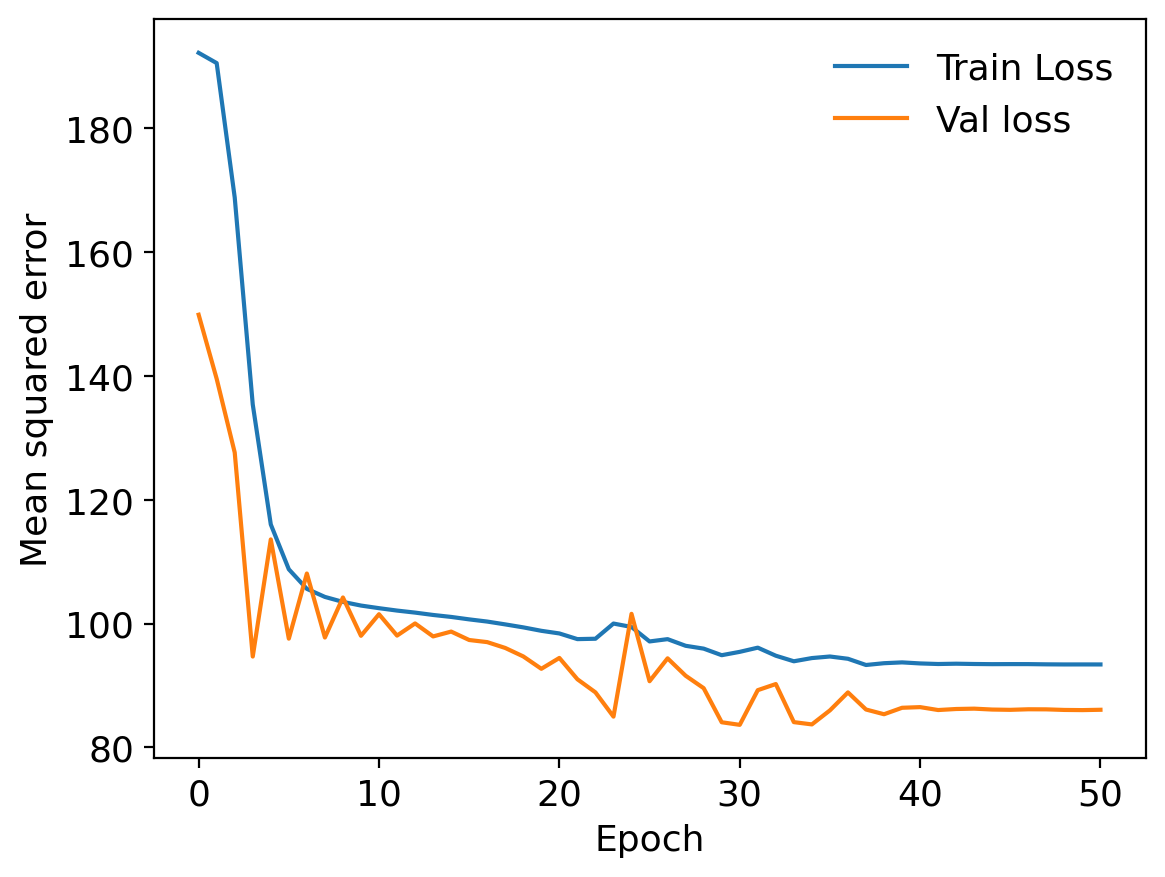

In [50]:
plot_history(history)

In [19]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [20]:
lstm_model.save(os.path.join(model_path,'LSTM_model_1_member.h5'))

## Testing

In [21]:
lstm_model = load_model(os.path.join(model_path,'LSTM_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [51]:
y_test_df = pd.DataFrame(output_test.velsurf_mag.stack(dim=["y", "x"]).to_pandas())

In [52]:
y_test = y_test_df.to_numpy()

In [53]:
y_test_pre = lstm_model.predict(X_test)


3/3 [==============================] - 0s 3ms/step


In [54]:
y_test_pre_rs = y_test_pre.reshape(y_test_pre.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': input_test.time.values[slider-1:], 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [55]:
y_true =  y_test_df.unstack().to_xarray()

In [56]:
y_true

<xarray.DataArray (y: 381, x: 381, time: 100)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y        (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * x        (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * time     (time) float64 -8.48e+04 -8.47e+04 -8.46e+04 ... -7.5e+04 -7.49e+04

In [57]:
y_test_pre_xr = y_test_pre_xr + y_true - y_true

In [58]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:      (time: 96, x: 381, y: 381)
Coordinates:
  * time         (time) float64 -8.44e+04 -8.43e+04 ... -7.5e+04 -7.49e+04
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velsurf_mag  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

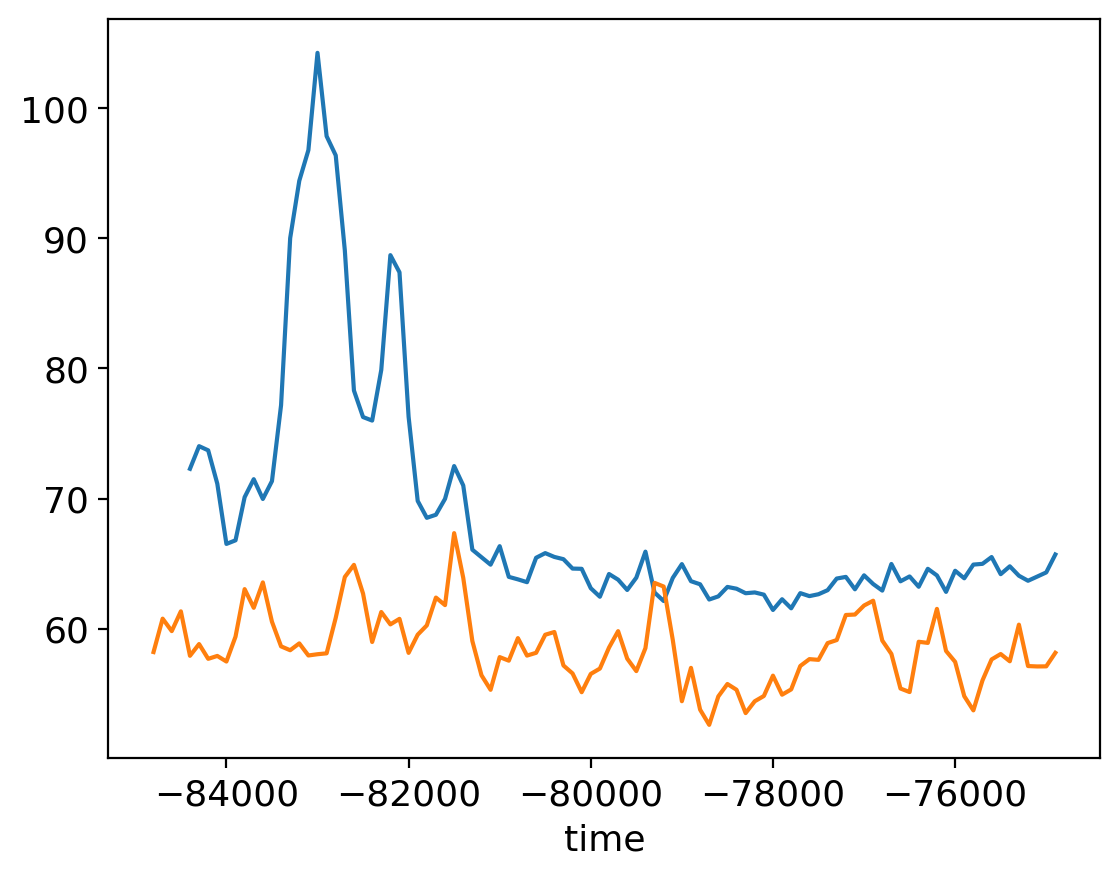

In [59]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()

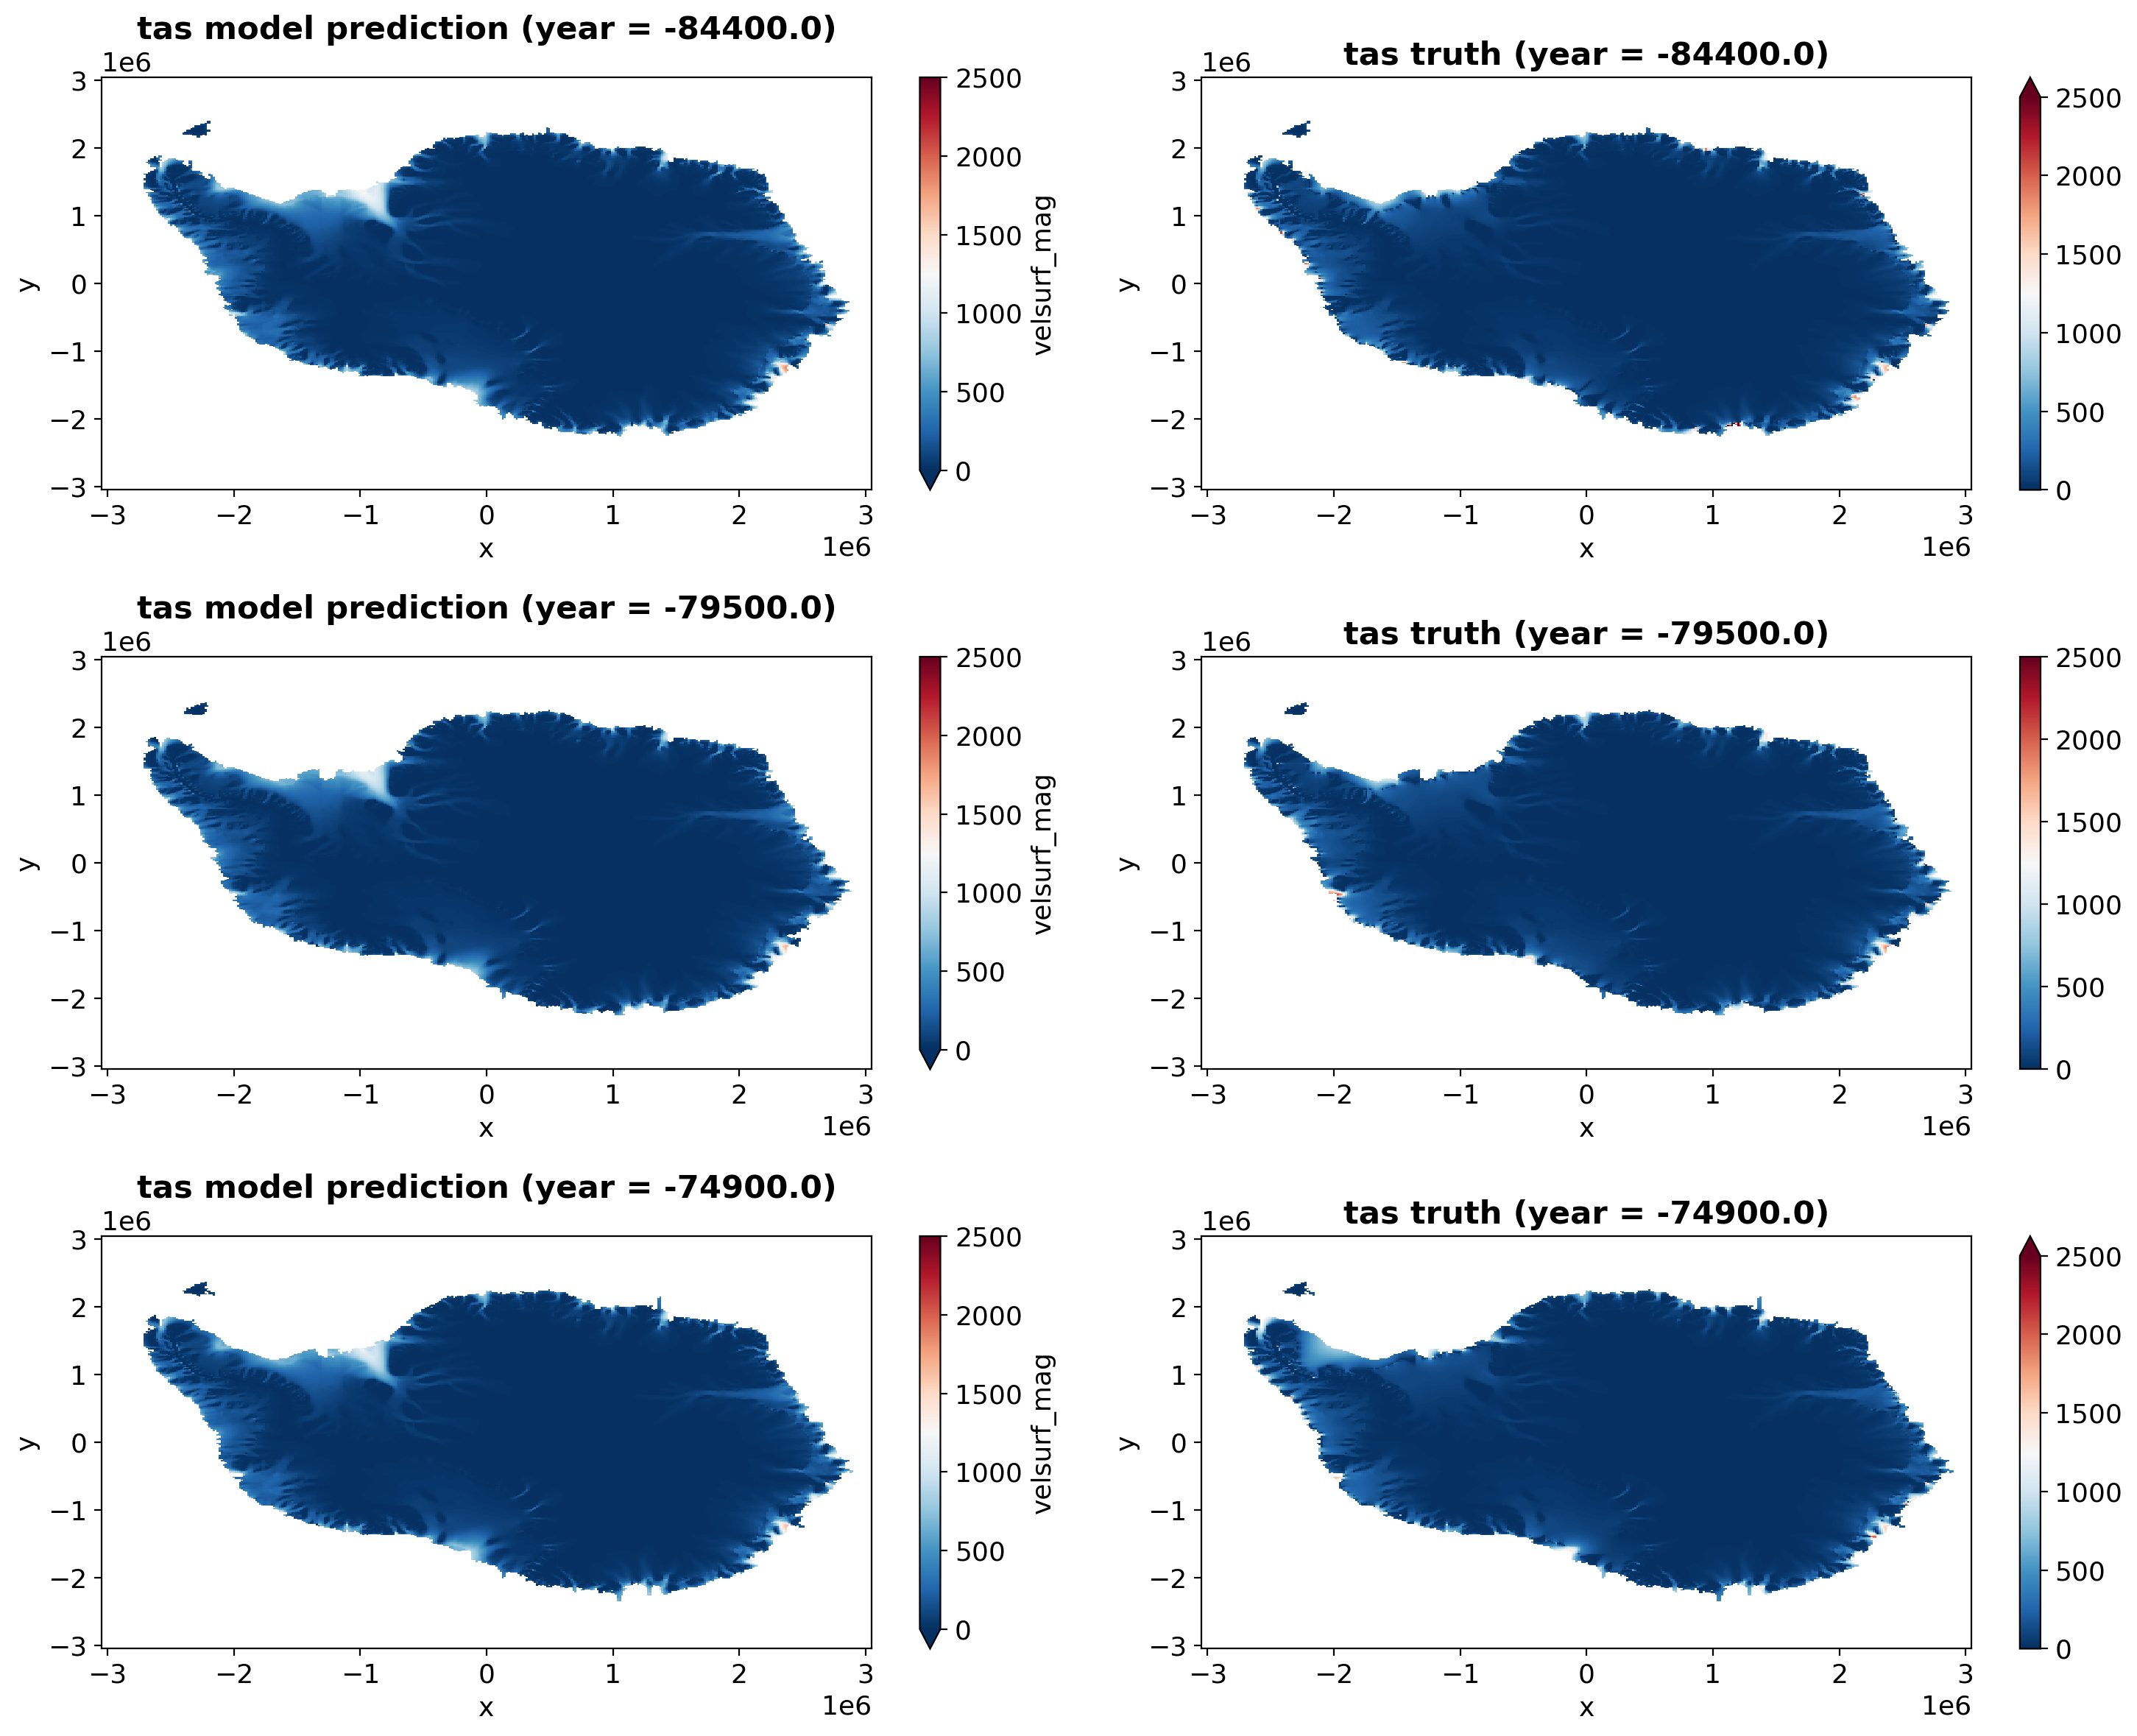

In [60]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [y_test_pre_xr.time[0].values, y_test_pre_xr.time[49].values, y_test_pre_xr.time[-1].values]
vmin, vmax    = 0, 2500
cmap = 'RdBu_r'
y_test_pre_xr.velsurf_mag.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

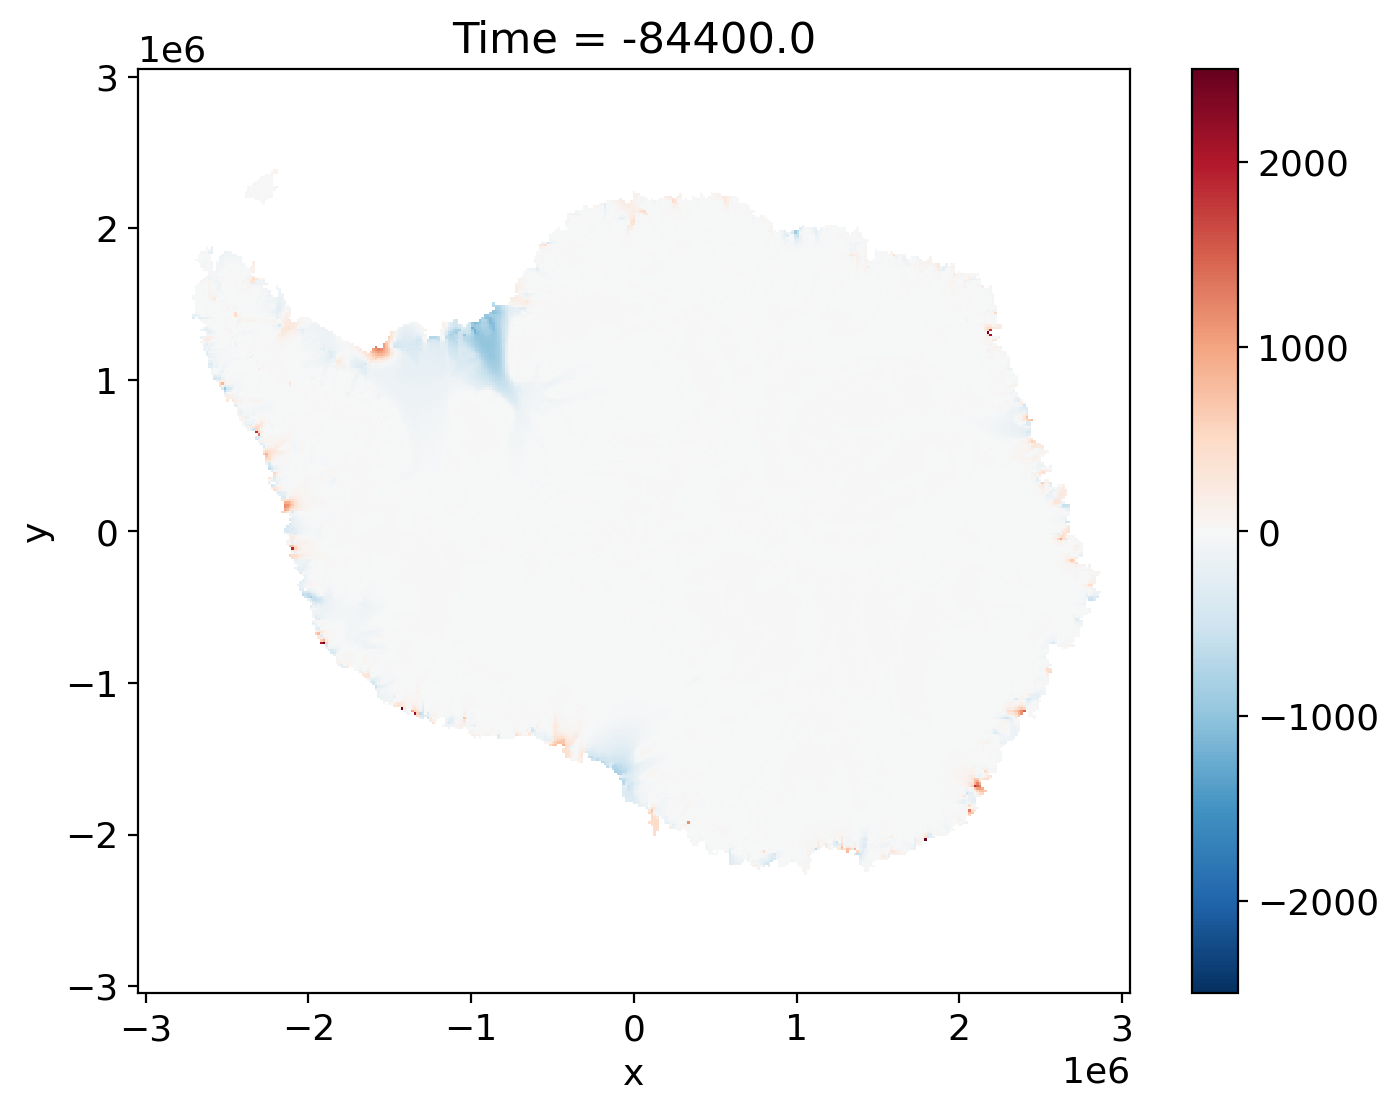

In [61]:
from matplotlib import animation
fig, ax = plt.subplots(figsize=(8,6))
cmap = 'Blues_r'
diff_min,diff_max = -2500,2500
diff_map = 'RdBu_r'
plt_diff = (y_true.isel(time = 2)-y_test_pre_xr.velsurf_mag.isel(time = 0)).plot(vmin=diff_min, vmax=diff_max,cmap=diff_map,cbar_kwargs={
        'extend':'neither'
    })


def animate(i):
    plt_diff.set_array(y_true.isel(time = i*4+1)-y_test_pre_xr.velsurf_mag.isel(time = i*4))
    ax.set_title("Time = " + str(y_test_pre_xr.time.values[i*4]))
anim = animation.FuncAnimation(fig, animate, frames=y_test_pre_xr.time.size//4, repeat=True)


In [62]:
from IPython.display import HTML, display

HTML(anim.to_jshtml())


In [48]:
#anim.save('animation.gif')
